In [2]:
import gensim
import pandas as pd
import keras
import pickle
import numpy as np

In [3]:
filename='preprocessed_data.pkl'

In [4]:
data=pickle.load(open(filename,'rb')) ###open preprocessed data

In [5]:
len(data)

8450

In [6]:
data.head()

,Transcript,Class 1
0,shattered chiromo mortuary and positively iden...,0
1,heading game chicken end game inevitable it be...,0
2,know else shit tech industry nothing designed ...,0
3,laverokbirdfood bluefrogtoys peacockspro jjeve...,0
4,reposting please refrain sharing video suicide...,0


In [7]:
Y= data.iloc[:,1].values
Y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [8]:
###Manually resolve the tabbed data errors

index = [791,  792,  793,  830,  831,  832,  833,  839,  844, 846, 852,  853,
         855,  858,  860,  876,  882,  890,  892,  904,  909,  912,  936,
         938,  943,  945,  957,  964,  965,  967,  969,  972,  975,  976,
        1000, 1007, 1013, 1018, 1297] 
for i in index:
    Y[i] = 0  ###replace value of selected indices of AD column with 0

idx = [1072, 1101, 1184, 1244]
for i in idx:
    Y[i] = 1  ###replace value of selected indices of AD column with 1
Y = Y.astype(int)

In [9]:
X = data['Transcript'].tolist()

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0) ##split the data in training and testing

In [12]:
print(len(X_train)) ###length of training, testing data
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

6760
1690
6760
1690


In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [14]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [15]:
train_tokenizer = create_tokens(X_train)

In [16]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X

In [17]:
X_train = encode_sentences(train_tokenizer,100, X_train)
X_test = encode_sentences(train_tokenizer,100, X_test)

In [18]:
print(X_train.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6760, 100)
(1690, 100)
(6760,)
(1690,)


In [19]:
vocab_len= len(train_tokenizer.word_index ) + 1 
vocab_len   ###vocab length

8741

In [32]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense 
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm

In [33]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =256, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [34]:
cnn_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Epoch 1/25
48/48 [==============================] - 5s 110ms/step - loss: 0.1920 - accuracy: 0.9224 - val_loss: 0.1406 - val_accuracy: 0.9512
Epoch 2/25
48/48 [==============================] - 5s 109ms/step - loss: 0.1063 - accuracy: 0.9610 - val_loss: 0.1420 - val_accuracy: 0.9571
Epoch 3/25
48/48 [==============================] - 5s 105ms/step - loss: 0.0699 - accuracy: 0.9727 - val_loss: 0.1363 - val_accuracy: 0.9615
Epoch 4/25
48/48 [==============================] - 5s 106ms/step - loss: 0.0460 - accuracy: 0.9826 - val_loss: 0.1588 - val_accuracy: 0.9527
Epoch 5/25
48/48 [==============================] - 5s 112ms/step - loss: 0.0295 - accuracy: 0.9896 - val_loss: 0.1909 - val_accuracy: 0.9571
Epoch 6/25
48/48 [==============================] - 5s 109ms/step - loss: 0.0176 - accuracy: 0.9947 - val_loss: 0.2468 - val_accuracy: 0.9615
Epoch 7/25
48/48 [==============================] - 5s 108ms/step - loss: 0.0123 - accuracy: 0.9957 - val_loss: 0.2737 - val_accuracy: 0.9586
Epoch 

In [35]:
score = model.evaluate(X_test,Y_test,verbose = 1)

53/53 [==============================] - 0s 7ms/step - loss: 0.5442 - accuracy: 0.9592


In [36]:
print('Accuracy of the model is {}'.format(score[1]))

Accuracy of the model is 0.9591715931892395


In [37]:
def model_cnn_create(neurons = 128, optimizer = 'Adam',
                 dropout_rate = 0.2, weight_constraint = 3, nb_filters = 256, kernel_size = 5):
    
    model = Sequential()
    model.add(Embedding(input_dim = vocab_len, output_dim = 100, input_length = 100))
    model.add(Conv1D(nb_filters, kernel_size, activation = 'relu',strides = 1, kernel_initializer= 'he_uniform'))   
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(units = neurons, kernel_constraint=maxnorm(weight_constraint),kernel_initializer= 'he_uniform', activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))   
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [38]:
param_grid = {
    'optimizer': ['RMSprop','Adam','SGD'],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] optimizer=RMSprop ...............................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


141/141 - 8s - loss: 0.1700 - accuracy: 0.9419
Epoch 2/10
141/141 - 8s - loss: 0.0965 - accuracy: 0.9680
Epoch 3/10
141/141 - 8s - loss: 0.0533 - accuracy: 0.9818
Epoch 4/10
141/141 - 8s - loss: 0.0268 - accuracy: 0.9920
Epoch 5/10
141/141 - 8s - loss: 0.0162 - accuracy: 0.9953
Epoch 6/10
141/141 - 8s - loss: 0.0130 - accuracy: 0.9958
Epoch 7/10
141/141 - 8s - loss: 0.0095 - accuracy: 0.9969
Epoch 8/10
141/141 - 8s - loss: 0.0093 - accuracy: 0.9967
Epoch 9/10
141/141 - 8s - loss: 0.0076 - accuracy: 0.9978
Epoch 10/10
141/141 - 8s - loss: 0.0076 - accuracy: 0.9978
71/71 - 1s - loss: 0.4266 - accuracy: 0.9361
[CV] ................................ optimizer=RMSprop, total= 1.4min
[CV] optimizer=RMSprop ...............................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


141/141 - 8s - loss: 0.1722 - accuracy: 0.9421
Epoch 2/10
141/141 - 8s - loss: 0.1020 - accuracy: 0.9614
Epoch 3/10
141/141 - 8s - loss: 0.0574 - accuracy: 0.9780
Epoch 4/10
141/141 - 8s - loss: 0.0274 - accuracy: 0.9891
Epoch 5/10
141/141 - 8s - loss: 0.0145 - accuracy: 0.9953
Epoch 6/10
141/141 - 8s - loss: 0.0094 - accuracy: 0.9980
Epoch 7/10
141/141 - 8s - loss: 0.0089 - accuracy: 0.9976
Epoch 8/10
141/141 - 8s - loss: 0.0072 - accuracy: 0.9973
Epoch 9/10
141/141 - 8s - loss: 0.0066 - accuracy: 0.9978
Epoch 10/10
141/141 - 8s - loss: 0.0062 - accuracy: 0.9980
71/71 - 1s - loss: 0.5588 - accuracy: 0.9614
[CV] ................................ optimizer=RMSprop, total= 1.3min
[CV] optimizer=RMSprop ...............................................
Epoch 1/10
141/141 - 8s - loss: 0.1764 - accuracy: 0.9432
Epoch 2/10
141/141 - 8s - loss: 0.1037 - accuracy: 0.9654
Epoch 3/10
141/141 - 8s - loss: 0.0571 - accuracy: 0.9785
Epoch 4/10
141/141 - 8s - loss: 0.0257 - accuracy: 0.9891
Epoch 5/10


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 10.8min finished


212/212 - 11s - loss: 0.1575 - accuracy: 0.9499
Epoch 2/10
212/212 - 11s - loss: 0.0585 - accuracy: 0.9774
Epoch 3/10
212/212 - 11s - loss: 0.0199 - accuracy: 0.9932
Epoch 4/10
212/212 - 11s - loss: 0.0100 - accuracy: 0.9969
Epoch 5/10
212/212 - 11s - loss: 0.0080 - accuracy: 0.9973
Epoch 6/10
212/212 - 11s - loss: 0.0073 - accuracy: 0.9976
Epoch 7/10
212/212 - 11s - loss: 0.0059 - accuracy: 0.9976
Epoch 8/10
212/212 - 11s - loss: 0.0053 - accuracy: 0.9979
Epoch 9/10
212/212 - 11s - loss: 0.0056 - accuracy: 0.9975
Epoch 10/10
212/212 - 11s - loss: 0.0053 - accuracy: 0.9981
Best accuracy:  0.9560650872760976
Best parameters:  {'optimizer': 'Adam'}


In [39]:
param_grid = {
    'dropout_rate':[0.1,0.2,0.3,0.4,0.5],
    'weight_constraint':[1,2,3,4,5],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] dropout_rate=0.1, weight_constraint=1 ...........................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


141/141 - 8s - loss: 0.1703 - accuracy: 0.9363
Epoch 2/10
141/141 - 7s - loss: 0.0807 - accuracy: 0.9698
Epoch 3/10
141/141 - 7s - loss: 0.0384 - accuracy: 0.9871
Epoch 4/10
141/141 - 7s - loss: 0.0229 - accuracy: 0.9942
Epoch 5/10
141/141 - 7s - loss: 0.0156 - accuracy: 0.9958
Epoch 6/10
141/141 - 7s - loss: 0.0126 - accuracy: 0.9967
Epoch 7/10
141/141 - 7s - loss: 0.0097 - accuracy: 0.9969
Epoch 8/10
141/141 - 8s - loss: 0.0095 - accuracy: 0.9978
Epoch 9/10
141/141 - 7s - loss: 0.0115 - accuracy: 0.9967
Epoch 10/10
141/141 - 8s - loss: 0.0081 - accuracy: 0.9978
71/71 - 1s - loss: 0.2817 - accuracy: 0.9534
[CV] ............ dropout_rate=0.1, weight_constraint=1, total= 1.3min
[CV] dropout_rate=0.1, weight_constraint=1 ...........................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


141/141 - 7s - loss: 0.1771 - accuracy: 0.9321
Epoch 2/10
141/141 - 7s - loss: 0.0891 - accuracy: 0.9692
Epoch 3/10
141/141 - 7s - loss: 0.0536 - accuracy: 0.9876
Epoch 4/10
141/141 - 7s - loss: 0.0310 - accuracy: 0.9927
Epoch 5/10
141/141 - 7s - loss: 0.0177 - accuracy: 0.9947
Epoch 6/10
141/141 - 7s - loss: 0.0125 - accuracy: 0.9964
Epoch 7/10
141/141 - 7s - loss: 0.0122 - accuracy: 0.9973
Epoch 8/10
141/141 - 7s - loss: 0.0100 - accuracy: 0.9971
Epoch 9/10
141/141 - 7s - loss: 0.0106 - accuracy: 0.9967
Epoch 10/10
141/141 - 7s - loss: 0.0114 - accuracy: 0.9971
71/71 - 1s - loss: 0.3617 - accuracy: 0.9587
[CV] ............ dropout_rate=0.1, weight_constraint=1, total= 1.2min
[CV] dropout_rate=0.1, weight_constraint=1 ...........................
Epoch 1/10
141/141 - 7s - loss: 0.1807 - accuracy: 0.9339
Epoch 2/10
141/141 - 7s - loss: 0.0846 - accuracy: 0.9685
Epoch 3/10
141/141 - 7s - loss: 0.0330 - accuracy: 0.9891
Epoch 4/10
141/141 - 7s - loss: 0.0181 - accuracy: 0.9940
Epoch 5/10


141/141 - 7s - loss: 0.0031 - accuracy: 0.9989
71/71 - 1s - loss: 0.2581 - accuracy: 0.9609
[CV] ............ dropout_rate=0.1, weight_constraint=4, total= 1.2min
[CV] dropout_rate=0.1, weight_constraint=5 ...........................
Epoch 1/10
141/141 - 7s - loss: 0.1742 - accuracy: 0.9401
Epoch 2/10
141/141 - 7s - loss: 0.0696 - accuracy: 0.9718
Epoch 3/10
141/141 - 7s - loss: 0.0238 - accuracy: 0.9911
Epoch 4/10
141/141 - 7s - loss: 0.0142 - accuracy: 0.9956
Epoch 5/10
141/141 - 7s - loss: 0.0109 - accuracy: 0.9971
Epoch 6/10
141/141 - 7s - loss: 0.0103 - accuracy: 0.9973
Epoch 7/10
141/141 - 7s - loss: 0.0066 - accuracy: 0.9980
Epoch 8/10
141/141 - 7s - loss: 0.0067 - accuracy: 0.9978
Epoch 9/10
141/141 - 7s - loss: 0.0052 - accuracy: 0.9976
Epoch 10/10
141/141 - 7s - loss: 0.0052 - accuracy: 0.9980
71/71 - 1s - loss: 0.2559 - accuracy: 0.9552
[CV] ............ dropout_rate=0.1, weight_constraint=5, total= 1.2min
[CV] dropout_rate=0.1, weight_constraint=5 ..........................

Epoch 6/10
141/141 - 7s - loss: 0.0072 - accuracy: 0.9980
Epoch 7/10
141/141 - 7s - loss: 0.0069 - accuracy: 0.9973
Epoch 8/10
141/141 - 7s - loss: 0.0061 - accuracy: 0.9978
Epoch 9/10
141/141 - 7s - loss: 0.0082 - accuracy: 0.9978
Epoch 10/10
141/141 - 7s - loss: 0.0091 - accuracy: 0.9973
71/71 - 1s - loss: 0.3069 - accuracy: 0.9538
[CV] ............ dropout_rate=0.2, weight_constraint=3, total= 1.2min
[CV] dropout_rate=0.2, weight_constraint=3 ...........................
Epoch 1/10
141/141 - 7s - loss: 0.1723 - accuracy: 0.9388
Epoch 2/10
141/141 - 7s - loss: 0.0799 - accuracy: 0.9723
Epoch 3/10
141/141 - 7s - loss: 0.0266 - accuracy: 0.9922
Epoch 4/10
141/141 - 7s - loss: 0.0107 - accuracy: 0.9964
Epoch 5/10
141/141 - 7s - loss: 0.0080 - accuracy: 0.9976
Epoch 6/10
141/141 - 7s - loss: 0.0081 - accuracy: 0.9973
Epoch 7/10
141/141 - 7s - loss: 0.0051 - accuracy: 0.9987
Epoch 8/10
141/141 - 7s - loss: 0.0066 - accuracy: 0.9980
Epoch 9/10
141/141 - 7s - loss: 0.0055 - accuracy: 0.9978


Epoch 2/10
141/141 - 7s - loss: 0.0711 - accuracy: 0.9743
Epoch 3/10
141/141 - 7s - loss: 0.0278 - accuracy: 0.9898
Epoch 4/10
141/141 - 7s - loss: 0.0140 - accuracy: 0.9958
Epoch 5/10
141/141 - 7s - loss: 0.0100 - accuracy: 0.9976
Epoch 6/10
141/141 - 7s - loss: 0.0087 - accuracy: 0.9973
Epoch 7/10
141/141 - 7s - loss: 0.0073 - accuracy: 0.9978
Epoch 8/10
141/141 - 7s - loss: 0.0089 - accuracy: 0.9978
Epoch 9/10
141/141 - 7s - loss: 0.0070 - accuracy: 0.9978
Epoch 10/10
141/141 - 7s - loss: 0.0059 - accuracy: 0.9980
71/71 - 1s - loss: 0.2755 - accuracy: 0.9587
[CV] ............ dropout_rate=0.3, weight_constraint=2, total= 1.2min
[CV] dropout_rate=0.3, weight_constraint=2 ...........................
Epoch 1/10
141/141 - 7s - loss: 0.1787 - accuracy: 0.9452
Epoch 2/10
141/141 - 7s - loss: 0.0758 - accuracy: 0.9689
Epoch 3/10
141/141 - 7s - loss: 0.0288 - accuracy: 0.9909
Epoch 4/10
141/141 - 7s - loss: 0.0137 - accuracy: 0.9973
Epoch 5/10
141/141 - 7s - loss: 0.0109 - accuracy: 0.9976


71/71 - 1s - loss: 0.2604 - accuracy: 0.9609
[CV] ............ dropout_rate=0.3, weight_constraint=5, total= 1.3min
[CV] dropout_rate=0.3, weight_constraint=5 ...........................
Epoch 1/10
141/141 - 7s - loss: 0.1717 - accuracy: 0.9396
Epoch 2/10
141/141 - 7s - loss: 0.0657 - accuracy: 0.9769
Epoch 3/10
141/141 - 7s - loss: 0.0214 - accuracy: 0.9927
Epoch 4/10
141/141 - 7s - loss: 0.0079 - accuracy: 0.9978
Epoch 5/10
141/141 - 8s - loss: 0.0051 - accuracy: 0.9984
Epoch 6/10
141/141 - 7s - loss: 0.0053 - accuracy: 0.9982
Epoch 7/10
141/141 - 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 8/10
141/141 - 7s - loss: 0.0029 - accuracy: 0.9996
Epoch 9/10
141/141 - 8s - loss: 0.0025 - accuracy: 0.9989
Epoch 10/10
141/141 - 7s - loss: 0.0028 - accuracy: 0.9993
71/71 - 1s - loss: 0.2847 - accuracy: 0.9636
[CV] ............ dropout_rate=0.3, weight_constraint=5, total= 1.3min
[CV] dropout_rate=0.4, weight_constraint=1 ...........................
Epoch 1/10
141/141 - 7s - loss: 0.1706 - accu

Epoch 7/10
141/141 - 7s - loss: 0.0061 - accuracy: 0.9973
Epoch 8/10
141/141 - 7s - loss: 0.0055 - accuracy: 0.9980
Epoch 9/10
141/141 - 7s - loss: 0.0055 - accuracy: 0.9978
Epoch 10/10
141/141 - 7s - loss: 0.0046 - accuracy: 0.9978
71/71 - 1s - loss: 0.2904 - accuracy: 0.9561
[CV] ............ dropout_rate=0.4, weight_constraint=4, total= 1.2min
[CV] dropout_rate=0.4, weight_constraint=4 ...........................
Epoch 1/10
141/141 - 7s - loss: 0.1749 - accuracy: 0.9441
Epoch 2/10
141/141 - 7s - loss: 0.0754 - accuracy: 0.9707
Epoch 3/10
141/141 - 7s - loss: 0.0220 - accuracy: 0.9929
Epoch 4/10
141/141 - 7s - loss: 0.0109 - accuracy: 0.9967
Epoch 5/10
141/141 - 7s - loss: 0.0070 - accuracy: 0.9978
Epoch 6/10
141/141 - 7s - loss: 0.0060 - accuracy: 0.9982
Epoch 7/10
141/141 - 7s - loss: 0.0059 - accuracy: 0.9984
Epoch 8/10
141/141 - 7s - loss: 0.0060 - accuracy: 0.9978
Epoch 9/10
141/141 - 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 10/10
141/141 - 7s - loss: 0.0043 - accuracy: 0.9982

Epoch 3/10
141/141 - 7s - loss: 0.0241 - accuracy: 0.9925
Epoch 4/10
141/141 - 7s - loss: 0.0093 - accuracy: 0.9976
Epoch 5/10
141/141 - 7s - loss: 0.0074 - accuracy: 0.9976
Epoch 6/10
141/141 - 7s - loss: 0.0078 - accuracy: 0.9978
Epoch 7/10
141/141 - 7s - loss: 0.0053 - accuracy: 0.9987
Epoch 8/10
141/141 - 7s - loss: 0.0045 - accuracy: 0.9987
Epoch 9/10
141/141 - 7s - loss: 0.0071 - accuracy: 0.9980
Epoch 10/10
141/141 - 7s - loss: 0.0056 - accuracy: 0.9987
71/71 - 1s - loss: 0.3250 - accuracy: 0.9521
[CV] ............ dropout_rate=0.5, weight_constraint=2, total= 1.2min
[CV] dropout_rate=0.5, weight_constraint=3 ...........................
Epoch 1/10
141/141 - 7s - loss: 0.1635 - accuracy: 0.9374
Epoch 2/10
141/141 - 7s - loss: 0.0748 - accuracy: 0.9720
Epoch 3/10
141/141 - 7s - loss: 0.0253 - accuracy: 0.9905
Epoch 4/10
141/141 - 7s - loss: 0.0118 - accuracy: 0.9969
Epoch 5/10
141/141 - 7s - loss: 0.0118 - accuracy: 0.9969
Epoch 6/10
141/141 - 7s - loss: 0.0081 - accuracy: 0.9978


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 93.0min finished


212/212 - 11s - loss: 0.1568 - accuracy: 0.9485
Epoch 2/10
212/212 - 11s - loss: 0.0674 - accuracy: 0.9741
Epoch 3/10
212/212 - 11s - loss: 0.0218 - accuracy: 0.9922
Epoch 4/10
212/212 - 11s - loss: 0.0106 - accuracy: 0.9962
Epoch 5/10
212/212 - 11s - loss: 0.0098 - accuracy: 0.9966
Epoch 6/10
212/212 - 11s - loss: 0.0077 - accuracy: 0.9972
Epoch 7/10
212/212 - 11s - loss: 0.0057 - accuracy: 0.9981
Epoch 8/10
212/212 - 11s - loss: 0.0050 - accuracy: 0.9984
Epoch 9/10
212/212 - 11s - loss: 0.0054 - accuracy: 0.9976
Epoch 10/10
212/212 - 11s - loss: 0.0046 - accuracy: 0.9973
Best accuracy:  0.9607988175555799
Best parameters:  {'dropout_rate': 0.2, 'weight_constraint': 4}


In [40]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100)
model.add(e)
model.add(Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =128, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(4)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [41]:
cnn_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Epoch 1/25
48/48 [==============================] - 8s 156ms/step - loss: 0.2080 - accuracy: 0.9255 - val_loss: 0.1448 - val_accuracy: 0.9482
Epoch 2/25
48/48 [==============================] - 7s 151ms/step - loss: 0.0945 - accuracy: 0.9597 - val_loss: 0.1282 - val_accuracy: 0.9541
Epoch 3/25
48/48 [==============================] - 8s 169ms/step - loss: 0.0490 - accuracy: 0.9783 - val_loss: 0.1624 - val_accuracy: 0.9541
Epoch 4/25
48/48 [==============================] - 8s 157ms/step - loss: 0.0267 - accuracy: 0.9903 - val_loss: 0.2191 - val_accuracy: 0.9512
Epoch 5/25
48/48 [==============================] - 9s 178ms/step - loss: 0.0160 - accuracy: 0.9947 - val_loss: 0.2680 - val_accuracy: 0.9615
Epoch 6/25
48/48 [==============================] - 8s 161ms/step - loss: 0.0142 - accuracy: 0.9947 - val_loss: 0.3418 - val_accuracy: 0.9689
Epoch 7/25
48/48 [==============================] - 8s 165ms/step - loss: 0.0115 - accuracy: 0.9959 - val_loss: 0.3074 - val_accuracy: 0.9497
Epoch 

In [42]:
score = model.evaluate(X_test,Y_test,verbose = 1)

53/53 [==============================] - 1s 10ms/step - loss: 0.4705 - accuracy: 0.9574


In [43]:
print('Accuracy of the model is {}'.format(score[1]))     ###Accuracy on test data

Accuracy of the model is 0.9573964476585388


In [44]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

<Figure size 640x480 with 1 Axes>

In [45]:
model.save('cnn_model.hdf5')   ###save the model

In [46]:
from tensorflow.keras.models import load_model  ###load the model

In [47]:
model.load_weights('cnn_model.hdf5')

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [49]:
Y_pred=model.predict(X_test)
Y_pred =(Y_pred>0.5)

In [50]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[1560   30]
 [  42   58]]
precision is 0.6590909090909091
recall is  0.58
F1 score 0.6170212765957446
specificity is 0.9811320754716981


Instructions for updating:
Please use `model.predict()` instead.


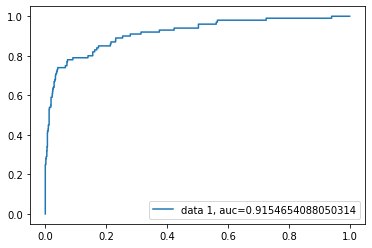

In [51]:
Y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [52]:
embeddings = dict()                                 ##read glove vector file
f = open('C:/Users/HP/Desktop/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:],dtype='float32')
    embeddings[word]=vectors
f.close()


In [53]:
embedding_matrix = np.zeros((vocab_len, 100))      ###create a matrix consist of words and its vectors
for word, i in train_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [54]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable = False)
model.add(e)
model.add(Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =128, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(4)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [55]:
cnn_pretrained_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Epoch 1/25
48/48 [==============================] - 6s 121ms/step - loss: 0.2045 - accuracy: 0.9193 - val_loss: 0.1436 - val_accuracy: 0.9393
Epoch 2/25
48/48 [==============================] - 6s 121ms/step - loss: 0.1296 - accuracy: 0.9384 - val_loss: 0.1197 - val_accuracy: 0.9482
Epoch 3/25
48/48 [==============================] - 6s 119ms/step - loss: 0.1022 - accuracy: 0.9530 - val_loss: 0.1075 - val_accuracy: 0.9571
Epoch 4/25
48/48 [==============================] - 6s 121ms/step - loss: 0.0734 - accuracy: 0.9693 - val_loss: 0.0970 - val_accuracy: 0.9645
Epoch 5/25
48/48 [==============================] - 6s 127ms/step - loss: 0.0444 - accuracy: 0.9832 - val_loss: 0.1003 - val_accuracy: 0.9675
Epoch 6/25
48/48 [==============================] - 6s 127ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.1024 - val_accuracy: 0.9689
Epoch 7/25
48/48 [==============================] - 7s 136ms/step - loss: 0.0165 - accuracy: 0.9952 - val_loss: 0.1349 - val_accuracy: 0.9689
Epoch 

In [56]:
score = model.evaluate(X_test,Y_test,verbose = 1)

53/53 [==============================] - 0s 8ms/step - loss: 0.2489 - accuracy: 0.9621


In [57]:
score[1]

0.9621301889419556

In [58]:
def model_cnn_create(neurons = 128, optimizer = 'Adam',
                 dropout_rate = 0.2, weight_constraint = 3, nb_filters = 256, kernel_size = 5):
    
    model = Sequential()
    e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable = False)
    model.add(e)
    model.add(Conv1D(nb_filters, kernel_size, activation = 'relu',strides = 1, kernel_initializer= 'he_uniform'))   
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(units = neurons, kernel_constraint=maxnorm(weight_constraint),kernel_initializer= 'he_uniform', activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))   
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [59]:
param_grid = {
    'optimizer': ['RMSprop','Adam','SGD'],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] optimizer=RMSprop ...............................................
Epoch 1/10
141/141 - 7s - loss: 0.1568 - accuracy: 0.9483
Epoch 2/10
141/141 - 7s - loss: 0.0775 - accuracy: 0.9723
Epoch 3/10
141/141 - 6s - loss: 0.0321 - accuracy: 0.9885
Epoch 4/10
141/141 - 7s - loss: 0.0184 - accuracy: 0.9938
Epoch 5/10
141/141 - 6s - loss: 0.0126 - accuracy: 0.9962
Epoch 6/10
141/141 - 6s - loss: 0.0151 - accuracy: 0.9967
Epoch 7/10
141/141 - 7s - loss: 0.0080 - accuracy: 0.9971
Epoch 8/10
141/141 - 6s - loss: 0.0082 - accuracy: 0.9973
Epoch 9/10
141/141 - 7s - loss: 0.0114 - accuracy: 0.9973
Epoch 10/10
141/141 - 6s - loss: 0.0056 - accuracy: 0.9980
71/71 - 0s - loss: 0.5183 - accuracy: 0.9623
[CV] ................................ optimizer=RMSprop, total= 1.1min
[CV] optimizer=RMSprop ...............................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


141/141 - 7s - loss: 0.1548 - accuracy: 0.9483
Epoch 2/10
141/141 - 6s - loss: 0.0777 - accuracy: 0.9718
Epoch 3/10
141/141 - 6s - loss: 0.0342 - accuracy: 0.9878
Epoch 4/10
141/141 - 7s - loss: 0.0215 - accuracy: 0.9933
Epoch 5/10
141/141 - 6s - loss: 0.0167 - accuracy: 0.9931
Epoch 6/10
141/141 - 7s - loss: 0.0072 - accuracy: 0.9969
Epoch 7/10
141/141 - 6s - loss: 0.0060 - accuracy: 0.9980
Epoch 8/10
141/141 - 6s - loss: 0.0087 - accuracy: 0.9964
Epoch 9/10
141/141 - 6s - loss: 0.0068 - accuracy: 0.9967
Epoch 10/10
141/141 - 6s - loss: 0.0075 - accuracy: 0.9976
71/71 - 1s - loss: 0.3560 - accuracy: 0.9672
[CV] ................................ optimizer=RMSprop, total= 1.1min
[CV] optimizer=RMSprop ...............................................
Epoch 1/10
141/141 - 7s - loss: 0.1647 - accuracy: 0.9490
Epoch 2/10
141/141 - 6s - loss: 0.0792 - accuracy: 0.9720
Epoch 3/10
141/141 - 6s - loss: 0.0348 - accuracy: 0.9880
Epoch 4/10
141/141 - 6s - loss: 0.0156 - accuracy: 0.9945
Epoch 5/10


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.5min finished


212/212 - 11s - loss: 0.1494 - accuracy: 0.9504
Epoch 2/10
212/212 - 11s - loss: 0.0754 - accuracy: 0.9726
Epoch 3/10
212/212 - 11s - loss: 0.0361 - accuracy: 0.9871
Epoch 4/10
212/212 - 10s - loss: 0.0183 - accuracy: 0.9939
Epoch 5/10
212/212 - 10s - loss: 0.0130 - accuracy: 0.9957
Epoch 6/10
212/212 - 10s - loss: 0.0127 - accuracy: 0.9956
Epoch 7/10
212/212 - 10s - loss: 0.0097 - accuracy: 0.9969
Epoch 8/10
212/212 - 10s - loss: 0.0132 - accuracy: 0.9966
Epoch 9/10
212/212 - 11s - loss: 0.0103 - accuracy: 0.9962
Epoch 10/10
212/212 - 10s - loss: 0.0074 - accuracy: 0.9978
Best accuracy:  0.9650887678713488
Best parameters:  {'optimizer': 'RMSprop'}


In [60]:
param_grid = {
    'neurons': [128,256]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] neurons=128 .....................................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


141/141 - 5s - loss: 0.1527 - accuracy: 0.9465
Epoch 2/10
141/141 - 5s - loss: 0.0731 - accuracy: 0.9731
Epoch 3/10
141/141 - 6s - loss: 0.0311 - accuracy: 0.9880
Epoch 4/10
141/141 - 7s - loss: 0.0129 - accuracy: 0.9964
Epoch 5/10
141/141 - 6s - loss: 0.0100 - accuracy: 0.9973
Epoch 6/10
141/141 - 6s - loss: 0.0081 - accuracy: 0.9976
Epoch 7/10
141/141 - 5s - loss: 0.0053 - accuracy: 0.9978
Epoch 8/10
141/141 - 6s - loss: 0.0044 - accuracy: 0.9978
Epoch 9/10
141/141 - 5s - loss: 0.0039 - accuracy: 0.9982
Epoch 10/10
141/141 - 6s - loss: 0.0035 - accuracy: 0.9982
71/71 - 1s - loss: 0.2554 - accuracy: 0.9650
[CV] ...................................... neurons=128, total=  57.5s
[CV] neurons=128 .....................................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.4s remaining:    0.0s


141/141 - 6s - loss: 0.1602 - accuracy: 0.9388
Epoch 2/10
141/141 - 5s - loss: 0.0797 - accuracy: 0.9680
Epoch 3/10
141/141 - 5s - loss: 0.0357 - accuracy: 0.9867
Epoch 4/10
141/141 - 5s - loss: 0.0166 - accuracy: 0.9951
Epoch 5/10
141/141 - 5s - loss: 0.0088 - accuracy: 0.9971
Epoch 6/10
141/141 - 5s - loss: 0.0084 - accuracy: 0.9973
Epoch 7/10
141/141 - 6s - loss: 0.0055 - accuracy: 0.9978
Epoch 8/10
141/141 - 5s - loss: 0.0052 - accuracy: 0.9976
Epoch 9/10
141/141 - 6s - loss: 0.0046 - accuracy: 0.9978
Epoch 10/10
141/141 - 6s - loss: 0.0042 - accuracy: 0.9980
71/71 - 1s - loss: 0.2251 - accuracy: 0.9614
[CV] ...................................... neurons=128, total=  56.5s
[CV] neurons=128 .....................................................
Epoch 1/10
141/141 - 5s - loss: 0.1641 - accuracy: 0.9403
Epoch 2/10
141/141 - 5s - loss: 0.0861 - accuracy: 0.9680
Epoch 3/10
141/141 - 6s - loss: 0.0296 - accuracy: 0.9907
Epoch 4/10
141/141 - 6s - loss: 0.0125 - accuracy: 0.9971
Epoch 5/10


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.0min finished


212/212 - 13s - loss: 0.1496 - accuracy: 0.9456
Epoch 2/10
212/212 - 14s - loss: 0.0760 - accuracy: 0.9706
Epoch 3/10
212/212 - 14s - loss: 0.0318 - accuracy: 0.9886
Epoch 4/10
212/212 - 14s - loss: 0.0170 - accuracy: 0.9936
Epoch 5/10
212/212 - 14s - loss: 0.0126 - accuracy: 0.9957
Epoch 6/10
212/212 - 14s - loss: 0.0119 - accuracy: 0.9953
Epoch 7/10
212/212 - 14s - loss: 0.0083 - accuracy: 0.9966
Epoch 8/10
212/212 - 14s - loss: 0.0058 - accuracy: 0.9975
Epoch 9/10
212/212 - 14s - loss: 0.0048 - accuracy: 0.9979
Epoch 10/10
212/212 - 14s - loss: 0.0041 - accuracy: 0.9981
Best accuracy:  0.9655325616605183
Best parameters:  {'neurons': 256}


In [61]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


141/141 - 2s - loss: 0.1644 - accuracy: 0.9390
Epoch 2/10
141/141 - 2s - loss: 0.0913 - accuracy: 0.9687
Epoch 3/10
141/141 - 2s - loss: 0.0467 - accuracy: 0.9854
Epoch 4/10
141/141 - 2s - loss: 0.0217 - accuracy: 0.9936
Epoch 5/10
141/141 - 2s - loss: 0.0142 - accuracy: 0.9958
Epoch 6/10
141/141 - 2s - loss: 0.0078 - accuracy: 0.9976
Epoch 7/10
141/141 - 2s - loss: 0.0114 - accuracy: 0.9964
Epoch 8/10
141/141 - 2s - loss: 0.0077 - accuracy: 0.9980
Epoch 9/10
141/141 - 2s - loss: 0.0060 - accuracy: 0.9978
Epoch 10/10
141/141 - 2s - loss: 0.0048 - accuracy: 0.9984
71/71 - 0s - loss: 0.2184 - accuracy: 0.9618
[CV] .................... kernel_size=3, nb_filters=128, total=  23.8s
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.7s remaining:    0.0s


141/141 - 3s - loss: 0.1672 - accuracy: 0.9381
Epoch 2/10
141/141 - 3s - loss: 0.0973 - accuracy: 0.9632
Epoch 3/10
141/141 - 3s - loss: 0.0459 - accuracy: 0.9840
Epoch 4/10
141/141 - 2s - loss: 0.0221 - accuracy: 0.9929
Epoch 5/10
141/141 - 2s - loss: 0.0106 - accuracy: 0.9969
Epoch 6/10
141/141 - 2s - loss: 0.0083 - accuracy: 0.9969
Epoch 7/10
141/141 - 2s - loss: 0.0053 - accuracy: 0.9978
Epoch 8/10
141/141 - 2s - loss: 0.0042 - accuracy: 0.9978
Epoch 9/10
141/141 - 2s - loss: 0.0038 - accuracy: 0.9976
Epoch 10/10
141/141 - 3s - loss: 0.0037 - accuracy: 0.9978
71/71 - 0s - loss: 0.2199 - accuracy: 0.9672
[CV] .................... kernel_size=3, nb_filters=128, total=  26.1s
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/10
141/141 - 2s - loss: 0.1708 - accuracy: 0.9374
Epoch 2/10
141/141 - 2s - loss: 0.1007 - accuracy: 0.9649
Epoch 3/10
141/141 - 2s - loss: 0.0496 - accuracy: 0.9820
Epoch 4/10
141/141 - 2s - loss: 0.0225 - accuracy: 0.9927
Epoch 5/10


141/141 - 5s - loss: 0.0024 - accuracy: 0.9993
71/71 - 1s - loss: 0.2219 - accuracy: 0.9680
[CV] .................... kernel_size=5, nb_filters=256, total=  54.3s
Epoch 1/10


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  7.9min finished


212/212 - 8s - loss: 0.1381 - accuracy: 0.9506
Epoch 2/10
212/212 - 8s - loss: 0.0673 - accuracy: 0.9762
Epoch 3/10
212/212 - 8s - loss: 0.0265 - accuracy: 0.9907
Epoch 4/10
212/212 - 9s - loss: 0.0145 - accuracy: 0.9953
Epoch 5/10
212/212 - 9s - loss: 0.0105 - accuracy: 0.9962
Epoch 6/10
212/212 - 8s - loss: 0.0077 - accuracy: 0.9975
Epoch 7/10
212/212 - 8s - loss: 0.0070 - accuracy: 0.9975
Epoch 8/10
212/212 - 8s - loss: 0.0099 - accuracy: 0.9962
Epoch 9/10
212/212 - 9s - loss: 0.0216 - accuracy: 0.9917
Epoch 10/10
212/212 - 8s - loss: 0.0148 - accuracy: 0.9942
Best accuracy:  0.9668639115592432
Best parameters:  {'kernel_size': 5, 'nb_filters': 256}


In [62]:
param_grid = {
    'dropout_rate': [0.1,0.2,0.3,0.4,0.5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] dropout_rate=0.1 ................................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


141/141 - 5s - loss: 0.1623 - accuracy: 0.9450
Epoch 2/10
141/141 - 5s - loss: 0.0749 - accuracy: 0.9709
Epoch 3/10
141/141 - 5s - loss: 0.0338 - accuracy: 0.9889
Epoch 4/10
141/141 - 5s - loss: 0.0152 - accuracy: 0.9953
Epoch 5/10
141/141 - 5s - loss: 0.0130 - accuracy: 0.9969
Epoch 6/10
141/141 - 5s - loss: 0.0082 - accuracy: 0.9978
Epoch 7/10
141/141 - 5s - loss: 0.0069 - accuracy: 0.9980
Epoch 8/10
141/141 - 5s - loss: 0.0056 - accuracy: 0.9980
Epoch 9/10
141/141 - 5s - loss: 0.0044 - accuracy: 0.9984
Epoch 10/10
141/141 - 5s - loss: 0.0044 - accuracy: 0.9984
71/71 - 1s - loss: 0.2500 - accuracy: 0.9663
[CV] ................................. dropout_rate=0.1, total=  53.1s
[CV] dropout_rate=0.1 ................................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.0s remaining:    0.0s


141/141 - 5s - loss: 0.1563 - accuracy: 0.9479
Epoch 2/10
141/141 - 5s - loss: 0.0681 - accuracy: 0.9749
Epoch 3/10
141/141 - 5s - loss: 0.0275 - accuracy: 0.9902
Epoch 4/10
141/141 - 5s - loss: 0.0156 - accuracy: 0.9949
Epoch 5/10
141/141 - 5s - loss: 0.0104 - accuracy: 0.9962
Epoch 6/10
141/141 - 5s - loss: 0.0064 - accuracy: 0.9976
Epoch 7/10
141/141 - 5s - loss: 0.0046 - accuracy: 0.9982
Epoch 8/10
141/141 - 5s - loss: 0.0045 - accuracy: 0.9980
Epoch 9/10
141/141 - 5s - loss: 0.0040 - accuracy: 0.9978
Epoch 10/10
141/141 - 5s - loss: 0.0037 - accuracy: 0.9980
71/71 - 1s - loss: 0.2161 - accuracy: 0.9676
[CV] ................................. dropout_rate=0.1, total=  54.0s
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
141/141 - 5s - loss: 0.1627 - accuracy: 0.9421
Epoch 2/10
141/141 - 5s - loss: 0.0799 - accuracy: 0.9687
Epoch 3/10
141/141 - 5s - loss: 0.0293 - accuracy: 0.9902
Epoch 4/10
141/141 - 5s - loss: 0.0151 - accuracy: 0.9947
Epoch 5/10


141/141 - 5s - loss: 0.0033 - accuracy: 0.9989
71/71 - 1s - loss: 0.2280 - accuracy: 0.9694
[CV] ................................. dropout_rate=0.4, total=  56.8s
[CV] dropout_rate=0.5 ................................................
Epoch 1/10
141/141 - 5s - loss: 0.1611 - accuracy: 0.9361
Epoch 2/10
141/141 - 5s - loss: 0.0853 - accuracy: 0.9687
Epoch 3/10
141/141 - 5s - loss: 0.0395 - accuracy: 0.9845
Epoch 4/10
141/141 - 5s - loss: 0.0172 - accuracy: 0.9951
Epoch 5/10
141/141 - 5s - loss: 0.0123 - accuracy: 0.9976
Epoch 6/10
141/141 - 5s - loss: 0.0096 - accuracy: 0.9973
Epoch 7/10
141/141 - 5s - loss: 0.0071 - accuracy: 0.9978
Epoch 8/10
141/141 - 5s - loss: 0.0064 - accuracy: 0.9980
Epoch 9/10
141/141 - 5s - loss: 0.0048 - accuracy: 0.9982
Epoch 10/10
141/141 - 5s - loss: 0.0045 - accuracy: 0.9980
71/71 - 1s - loss: 0.2513 - accuracy: 0.9632
[CV] ................................. dropout_rate=0.5, total=  55.1s
[CV] dropout_rate=0.5 ...............................................

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 14.2min finished


212/212 - 8s - loss: 0.1461 - accuracy: 0.9435
Epoch 2/10
212/212 - 9s - loss: 0.0730 - accuracy: 0.9719
Epoch 3/10
212/212 - 10s - loss: 0.0342 - accuracy: 0.9873
Epoch 4/10
212/212 - 9s - loss: 0.0190 - accuracy: 0.9945
Epoch 5/10
212/212 - 9s - loss: 0.0116 - accuracy: 0.9964
Epoch 6/10
212/212 - 9s - loss: 0.0085 - accuracy: 0.9975
Epoch 7/10
212/212 - 10s - loss: 0.0080 - accuracy: 0.9972
Epoch 8/10
212/212 - 11s - loss: 0.0070 - accuracy: 0.9969
Epoch 9/10
212/212 - 10s - loss: 0.0060 - accuracy: 0.9973
Epoch 10/10
212/212 - 10s - loss: 0.0256 - accuracy: 0.9904
Best accuracy:  0.9670118404739707
Best parameters:  {'dropout_rate': 0.1}


In [63]:
param_grid = {
    'weight_constraint': [1,2,3,4,5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] weight_constraint=1 .............................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


141/141 - 5s - loss: 0.1532 - accuracy: 0.9430
Epoch 2/10
141/141 - 5s - loss: 0.0843 - accuracy: 0.9683
Epoch 3/10
141/141 - 5s - loss: 0.0535 - accuracy: 0.9831
Epoch 4/10
141/141 - 5s - loss: 0.0334 - accuracy: 0.9929
Epoch 5/10
141/141 - 5s - loss: 0.0201 - accuracy: 0.9958
Epoch 6/10
141/141 - 5s - loss: 0.0172 - accuracy: 0.9945
Epoch 7/10
141/141 - 5s - loss: 0.0191 - accuracy: 0.9951
Epoch 8/10
141/141 - 5s - loss: 0.0150 - accuracy: 0.9969
Epoch 9/10
141/141 - 5s - loss: 0.0119 - accuracy: 0.9967
Epoch 10/10
141/141 - 5s - loss: 0.0103 - accuracy: 0.9971
71/71 - 1s - loss: 0.1977 - accuracy: 0.9583
[CV] .............................. weight_constraint=1, total=  52.4s
[CV] weight_constraint=1 .............................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.3s remaining:    0.0s


141/141 - 5s - loss: 0.1706 - accuracy: 0.9348
Epoch 2/10
141/141 - 5s - loss: 0.0959 - accuracy: 0.9621
Epoch 3/10
141/141 - 5s - loss: 0.0493 - accuracy: 0.9856
Epoch 4/10
141/141 - 5s - loss: 0.0302 - accuracy: 0.9920
Epoch 5/10
141/141 - 5s - loss: 0.0168 - accuracy: 0.9956
Epoch 6/10
141/141 - 5s - loss: 0.0107 - accuracy: 0.9978
Epoch 7/10
141/141 - 5s - loss: 0.0074 - accuracy: 0.9980
Epoch 8/10
141/141 - 5s - loss: 0.0090 - accuracy: 0.9969
Epoch 9/10
141/141 - 5s - loss: 0.0228 - accuracy: 0.9927
Epoch 10/10
141/141 - 5s - loss: 0.0133 - accuracy: 0.9958
71/71 - 1s - loss: 0.1646 - accuracy: 0.9587
[CV] .............................. weight_constraint=1, total=  54.0s
[CV] weight_constraint=1 .............................................
Epoch 1/10
141/141 - 5s - loss: 0.1649 - accuracy: 0.9348
Epoch 2/10
141/141 - 5s - loss: 0.0861 - accuracy: 0.9665
Epoch 3/10
141/141 - 5s - loss: 0.0491 - accuracy: 0.9854
Epoch 4/10
141/141 - 5s - loss: 0.0350 - accuracy: 0.9913
Epoch 5/10


141/141 - 5s - loss: 0.0027 - accuracy: 0.9993
71/71 - 1s - loss: 0.2270 - accuracy: 0.9694
[CV] .............................. weight_constraint=4, total=  52.3s
[CV] weight_constraint=5 .............................................
Epoch 1/10
141/141 - 5s - loss: 0.1631 - accuracy: 0.9363
Epoch 2/10
141/141 - 5s - loss: 0.0847 - accuracy: 0.9700
Epoch 3/10
141/141 - 6s - loss: 0.0404 - accuracy: 0.9869
Epoch 4/10
141/141 - 6s - loss: 0.0174 - accuracy: 0.9956
Epoch 5/10
141/141 - 6s - loss: 0.0114 - accuracy: 0.9969
Epoch 6/10
141/141 - 5s - loss: 0.0085 - accuracy: 0.9973
Epoch 7/10
141/141 - 5s - loss: 0.0079 - accuracy: 0.9976
Epoch 8/10
141/141 - 5s - loss: 0.0078 - accuracy: 0.9980
Epoch 9/10
141/141 - 5s - loss: 0.0090 - accuracy: 0.9973
Epoch 10/10
141/141 - 6s - loss: 0.0060 - accuracy: 0.9980
71/71 - 1s - loss: 0.2921 - accuracy: 0.9641
[CV] .............................. weight_constraint=5, total=  56.4s
[CV] weight_constraint=5 ............................................

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 13.5min finished


212/212 - 8s - loss: 0.1581 - accuracy: 0.9478
Epoch 2/10
212/212 - 8s - loss: 0.0742 - accuracy: 0.9731
Epoch 3/10
212/212 - 8s - loss: 0.0294 - accuracy: 0.9895
Epoch 4/10
212/212 - 8s - loss: 0.0190 - accuracy: 0.9936
Epoch 5/10
212/212 - 8s - loss: 0.0136 - accuracy: 0.9957
Epoch 6/10
212/212 - 8s - loss: 0.0106 - accuracy: 0.9959
Epoch 7/10
212/212 - 8s - loss: 0.0082 - accuracy: 0.9970
Epoch 8/10
212/212 - 8s - loss: 0.0068 - accuracy: 0.9978
Epoch 9/10
212/212 - 8s - loss: 0.0049 - accuracy: 0.9975
Epoch 10/10
212/212 - 8s - loss: 0.0051 - accuracy: 0.9984
Best accuracy:  0.9671597807100538
Best parameters:  {'weight_constraint': 4}


In [64]:
param_grid = {
    'batch_size': [32,64,128,256]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] batch_size=32 ...................................................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


141/141 - 6s - loss: 0.1625 - accuracy: 0.9359
Epoch 2/10
141/141 - 5s - loss: 0.0826 - accuracy: 0.9672
Epoch 3/10
141/141 - 6s - loss: 0.0385 - accuracy: 0.9874
Epoch 4/10
141/141 - 6s - loss: 0.0192 - accuracy: 0.9940
Epoch 5/10
141/141 - 5s - loss: 0.0125 - accuracy: 0.9967
Epoch 6/10
141/141 - 6s - loss: 0.0092 - accuracy: 0.9976
Epoch 7/10
141/141 - 6s - loss: 0.0068 - accuracy: 0.9984
Epoch 8/10
141/141 - 6s - loss: 0.0057 - accuracy: 0.9982
Epoch 9/10
141/141 - 7s - loss: 0.0049 - accuracy: 0.9984
Epoch 10/10
141/141 - 7s - loss: 0.0046 - accuracy: 0.9984
71/71 - 1s - loss: 0.2490 - accuracy: 0.9645
[CV] .................................... batch_size=32, total= 1.0min
[CV] batch_size=32 ...................................................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


141/141 - 6s - loss: 0.1586 - accuracy: 0.9372
Epoch 2/10
141/141 - 6s - loss: 0.0900 - accuracy: 0.9634
Epoch 3/10
141/141 - 6s - loss: 0.0436 - accuracy: 0.9869
Epoch 4/10
141/141 - 7s - loss: 0.0199 - accuracy: 0.9936
Epoch 5/10
141/141 - 6s - loss: 0.0118 - accuracy: 0.9958
Epoch 6/10
141/141 - 6s - loss: 0.0074 - accuracy: 0.9980
Epoch 7/10
141/141 - 6s - loss: 0.0062 - accuracy: 0.9971
Epoch 8/10
141/141 - 7s - loss: 0.0053 - accuracy: 0.9976
Epoch 9/10
141/141 - 7s - loss: 0.0047 - accuracy: 0.9980
Epoch 10/10
141/141 - 5s - loss: 0.0043 - accuracy: 0.9976
71/71 - 1s - loss: 0.2520 - accuracy: 0.9654
[CV] .................................... batch_size=32, total= 1.0min
[CV] batch_size=32 ...................................................
Epoch 1/10
141/141 - 5s - loss: 0.1666 - accuracy: 0.9350
Epoch 2/10
141/141 - 6s - loss: 0.0922 - accuracy: 0.9643
Epoch 3/10
141/141 - 7s - loss: 0.0365 - accuracy: 0.9871
Epoch 4/10
141/141 - 7s - loss: 0.0162 - accuracy: 0.9949
Epoch 5/10


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  8.6min finished


212/212 - 8s - loss: 0.1532 - accuracy: 0.9448
Epoch 2/10
212/212 - 8s - loss: 0.0787 - accuracy: 0.9714
Epoch 3/10
212/212 - 8s - loss: 0.0325 - accuracy: 0.9886
Epoch 4/10
212/212 - 8s - loss: 0.0177 - accuracy: 0.9929
Epoch 5/10
212/212 - 9s - loss: 0.0117 - accuracy: 0.9954
Epoch 6/10
212/212 - 8s - loss: 0.0130 - accuracy: 0.9959
Epoch 7/10
212/212 - 8s - loss: 0.0111 - accuracy: 0.9960
Epoch 8/10
212/212 - 8s - loss: 0.0058 - accuracy: 0.9978
Epoch 9/10
212/212 - 8s - loss: 0.0049 - accuracy: 0.9981
Epoch 10/10
212/212 - 8s - loss: 0.0058 - accuracy: 0.9981
Best accuracy:  0.9670118163323261
Best parameters:  {'batch_size': 32}


In [65]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable = False)
model.add(e)
model.add(Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =256, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(4)))
model.add(Dropout(0.1))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [66]:
cnn_pretrained_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 32, verbose = 1, validation_split = 0.1)

Epoch 1/25
191/191 [==============================] - 21s 110ms/step - loss: 0.1541 - accuracy: 0.9541 - val_loss: 0.1141 - val_accuracy: 0.9615
Epoch 2/25
191/191 [==============================] - 20s 107ms/step - loss: 0.0827 - accuracy: 0.9714 - val_loss: 0.1035 - val_accuracy: 0.9615
Epoch 3/25
191/191 [==============================] - 21s 112ms/step - loss: 0.0373 - accuracy: 0.9845 - val_loss: 0.1685 - val_accuracy: 0.9704
Epoch 4/25
191/191 [==============================] - 21s 109ms/step - loss: 0.0216 - accuracy: 0.9933 - val_loss: 0.2546 - val_accuracy: 0.9660
Epoch 5/25
191/191 [==============================] - 21s 108ms/step - loss: 0.0183 - accuracy: 0.9939 - val_loss: 0.2719 - val_accuracy: 0.9689
Epoch 6/25
191/191 [==============================] - 21s 108ms/step - loss: 0.0121 - accuracy: 0.9965 - val_loss: 0.3411 - val_accuracy: 0.9660
Epoch 7/25
191/191 [==============================] - 21s 110ms/step - loss: 0.0152 - accuracy: 0.9962 - val_loss: 0.3624 - val_ac

In [67]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

53/53 [==============================] - 1s 12ms/step - loss: 0.7979 - accuracy: 0.9657


0.9656804800033569

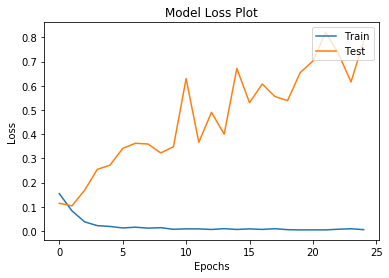

In [68]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_pretrained_history.history['loss'])
plt.plot(cnn_pretrained_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [70]:
model.save('cnn_pretrained_model.hdf5')

In [71]:
model.load_weights('cnn_pretrained_model.hdf5')

In [72]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [73]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[1574   16]
 [  42   58]]
precision is 0.7837837837837838
recall is  0.58
F1 score 0.6666666666666666
specificity is 0.989937106918239


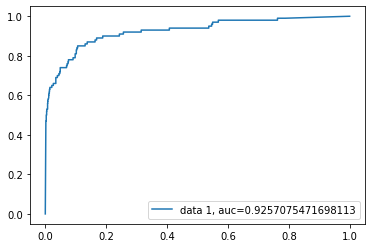

In [74]:
Y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()